In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, log_loss, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.utils import compute_class_weight

In [2]:
!pip install -U imbalanced-learn

In [3]:
# plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300

# import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [4]:
df = pd.read_csv(
    'datasets/healthcare-dataset-stroke-data.csv',
    index_col="id"
)



print(df.shape)
df.info()

(5110, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


In [5]:
df.reset_index(drop=True, inplace=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
print(df['gender'].unique())
print(df['ever_married'].unique())
print(df['work_type'].unique())
print(df['Residence_type'].unique())
print(df['smoking_status'].unique())

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


# Handling missing values in `bmi` column

Usiamo il SimpleImputer di sklearn

In [7]:
print("Missing values before imputation:", df['bmi'].isnull().sum())

Missing values before imputation: 201


In [8]:
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the 'bmi' column
imputer.fit(df[['bmi']])

# Transform the 'bmi' column by replacing missing values with the mean
df['bmi'] = imputer.transform(df[['bmi']])

In [9]:
print("Missing values after imputation:", df['bmi'].isnull().sum())

Missing values after imputation: 0


In [10]:
print(df.select_dtypes(include=['object']))         # <- stampiamo il sottoinsieme del dataframe con tipo 'object'
print(df.select_dtypes(include=['object']).columns) # <- stampiamo solo i nomi delle colonne di tipo 'object'
categorical_cols = list(df.select_dtypes(include=['object']).columns)
print(categorical_cols)




      gender ever_married      work_type Residence_type   smoking_status
0       Male          Yes        Private          Urban  formerly smoked
1     Female          Yes  Self-employed          Rural     never smoked
2       Male          Yes        Private          Rural     never smoked
3     Female          Yes        Private          Urban           smokes
4     Female          Yes  Self-employed          Rural     never smoked
...      ...          ...            ...            ...              ...
5105  Female          Yes        Private          Urban     never smoked
5106  Female          Yes  Self-employed          Urban     never smoked
5107  Female          Yes  Self-employed          Rural     never smoked
5108    Male          Yes        Private          Rural  formerly smoked
5109  Female          Yes       Govt_job          Urban          Unknown

[5110 rows x 5 columns]
Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dty

In [11]:
encoder = OneHotEncoder(handle_unknown='ignore')

encoded_cols = pd.DataFrame(
    encoder.fit_transform(df[categorical_cols]).toarray(), 
    columns=encoder.get_feature_names(categorical_cols)
)

encoded_cols

/Users/giumast/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5106,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5107,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5108,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [12]:
df_encoded = pd.concat(
    [df, encoded_cols], 
    axis=1
)
df_encoded.drop(categorical_cols, axis=1, inplace=True)

df = df_encoded.copy()

In [13]:
df_encoded.iloc[0, :]

age                                67.00
hypertension                        0.00
heart_disease                       1.00
avg_glucose_level                 228.69
bmi                                36.60
stroke                              1.00
gender_Female                       0.00
gender_Male                         1.00
gender_Other                        0.00
ever_married_No                     0.00
ever_married_Yes                    1.00
work_type_Govt_job                  0.00
work_type_Never_worked              0.00
work_type_Private                   1.00
work_type_Self-employed             0.00
work_type_children                  0.00
Residence_type_Rural                0.00
Residence_type_Urban                1.00
smoking_status_Unknown              0.00
smoking_status_formerly smoked      1.00
smoking_status_never smoked         0.00
smoking_status_smokes               0.00
Name: 0, dtype: float64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   hypertension                    5110 non-null   int64  
 2   heart_disease                   5110 non-null   int64  
 3   avg_glucose_level               5110 non-null   float64
 4   bmi                             5110 non-null   float64
 5   stroke                          5110 non-null   int64  
 6   gender_Female                   5110 non-null   float64
 7   gender_Male                     5110 non-null   float64
 8   gender_Other                    5110 non-null   float64
 9   ever_married_No                 5110 non-null   float64
 10  ever_married_Yes                5110 non-null   float64
 11  work_type_Govt_job              5110 non-null   float64
 12  work_type_Never_worked          51

['age', 'avg_glucose_level', 'bmi']


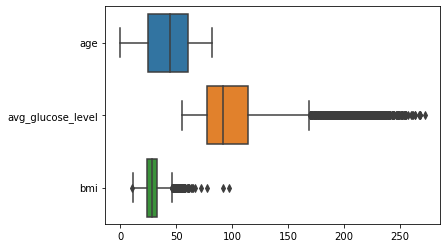

In [15]:
float_columns = ['age', 'avg_glucose_level', 'bmi']

print(float_columns)

sns.boxplot(data = df[float_columns], orient = "h")
plt.show()

<AxesSubplot:ylabel='Density'>

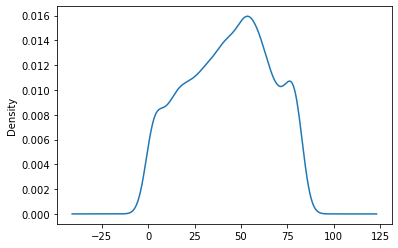

In [16]:
df['age'].plot(kind='kde')

<AxesSubplot:ylabel='Density'>

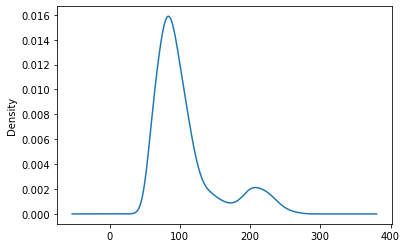

In [17]:
df['avg_glucose_level'].plot(kind='kde')

<AxesSubplot:ylabel='Density'>

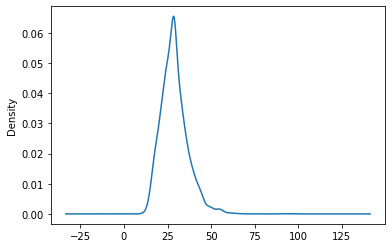

In [18]:
df['bmi'].plot(kind='kde')

In [19]:
scaler = StandardScaler()

# Fit and transform the selected numerical columns
df_encoded[float_columns] = scaler.fit_transform(df_encoded[float_columns])

# Print the updated DataFrame
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.600000,1,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,61.0,0,0,202.21,28.893237,1,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,80.0,0,1,105.92,32.500000,1,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,49.0,0,0,171.23,34.400000,1,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,79.0,1,0,174.12,24.000000,1,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


['age', 'avg_glucose_level', 'bmi']


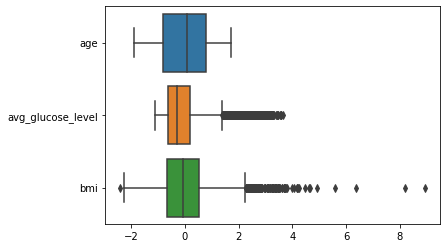

In [20]:
print(float_columns)

sns.boxplot(data = df_encoded[float_columns], orient = "h")
plt.show()

## Gestire gli outlier con IQR

Un approccio consiste nell'utilizzare percentili, come l'intervallo interquartile (IQR), per identificare i valori anomali. Le osservazioni che scendono al di sotto del quartile inferiore meno una certa soglia o al di sopra del quartile superiore più una certa soglia possono essere considerate valori anomali.



In [21]:
outlier_threshold = 1.5

for col in float_columns:
    # Calculate the IQR
    Q1 = df_encoded[col].quantile(0.25)
    Q3 = df_encoded[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define the upper and lower bounds for outliers
    lower_bound = Q1 - outlier_threshold * IQR
    upper_bound = Q3 + outlier_threshold * IQR
    
    print(f"{col} -> {lower_bound}, {upper_bound}")
    
    # remove outliers
    df_encoded = df_encoded[(df_encoded[col] >= lower_bound) & (df_encoded[col] <= upper_bound)]


# Print the updated DataFrame
df_encoded.shape

age -> -3.194393101644997, 3.1743479772447083
avg_glucose_level -> -1.858917758723901, 1.3960035056466606
bmi -> -2.461034925572104, 2.163984745475581


(4383, 22)

['age', 'avg_glucose_level', 'bmi']


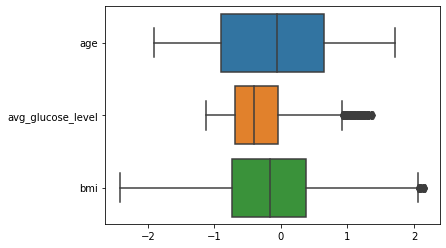

In [22]:
print(float_columns)

sns.boxplot(data = df_encoded[float_columns], orient = "h")
plt.show()

array([[<AxesSubplot:xlabel='age', ylabel='age'>,
        <AxesSubplot:xlabel='avg_glucose_level', ylabel='age'>,
        <AxesSubplot:xlabel='bmi', ylabel='age'>],
       [<AxesSubplot:xlabel='age', ylabel='avg_glucose_level'>,
        <AxesSubplot:xlabel='avg_glucose_level', ylabel='avg_glucose_level'>,
        <AxesSubplot:xlabel='bmi', ylabel='avg_glucose_level'>],
       [<AxesSubplot:xlabel='age', ylabel='bmi'>,
        <AxesSubplot:xlabel='avg_glucose_level', ylabel='bmi'>,
        <AxesSubplot:xlabel='bmi', ylabel='bmi'>]], dtype=object)

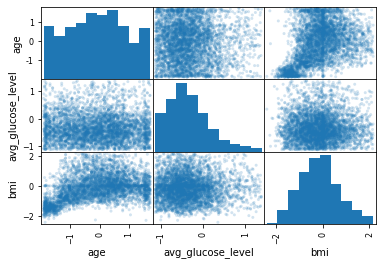

In [23]:
pd.plotting.scatter_matrix(df_encoded[float_columns], alpha=0.2)

stroke
0    4219
1     164
dtype: int64


<AxesSubplot:title={'center':'Distribuzione'}, xlabel='stroke'>

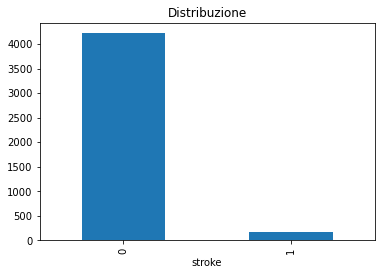

In [24]:
y_fieldname = "stroke"

print(df_encoded.pivot_table(index=y_fieldname, aggfunc="size"))
df_encoded.pivot_table(index=y_fieldname, aggfunc="size").plot(kind='bar', title="Distribuzione")

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    df_encoded, 
    df_encoded[y_fieldname], 
    stratify=df_encoded[y_fieldname], 
    random_state=42
)
X_train.drop([y_fieldname], axis=1)
X_test.drop([y_fieldname], axis=1)


print(X_train.shape)
print(X_test.shape)


(3287, 22)
(1096, 22)


<AxesSubplot:title={'center':'Distribuzione'}, xlabel='stroke'>

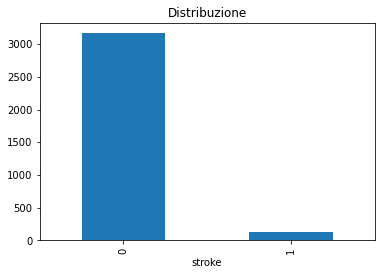

In [26]:
X_train.pivot_table(index=y_fieldname, aggfunc="size").plot(kind='bar', title="Distribuzione")

<AxesSubplot:title={'center':'Distribuzione'}, xlabel='stroke'>

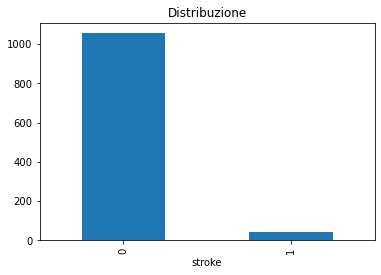

In [27]:
X_test.pivot_table(index=y_fieldname, aggfunc="size").plot(kind='bar', title="Distribuzione")

In [28]:
X_train.drop([y_fieldname], axis=1)
X_test.drop([y_fieldname], axis=1)


,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
1490,0.255342,1,0,0.038921,-5.057949e-01,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3214,-0.540751,0,0,-0.417801,4.615554e-16,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
553,0.520706,0,0,-0.661401,-1.290376e-01,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4900,-1.602208,0,0,-0.641083,-1.337259e+00,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
3539,-1.425298,0,0,-0.828807,-1.389226e+00,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,1.714845,0,0,-1.034200,5.595187e-01,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3368,-0.275387,0,0,-0.929295,-1.160460e-01,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1719,-0.408069,0,0,-0.433703,4.615554e-16,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3568,-0.186932,1,0,-0.396820,5.984935e-01,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [29]:
bad_preds = [0]*len(X_test)
# print(bad_preds)
print("Accuracy: {}".format(accuracy_score(y_test, bad_preds)))

Accuracy: 0.9625912408759124


In [30]:
# Se prediciamo sempre 0 tutte le metriche ci ritorneranno 0
# Se prediciamo sempre 1 avremo una recall pari a 1 perchè delle persone che comprano, il nostro modello ne rileva il 100%


print("Precision: {}".format(precision_score(y_test, bad_preds, zero_division=0)))
print("Recall: {}".format(recall_score(y_test, bad_preds)))
print("F1-Score: {}".format(f1_score(y_test, bad_preds)))


def evaluate(classifier, X_test, y_test, preds):
  tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
  print('True negatives: ', tn)
  print('\nFalse positives: ', fp)
  print('\nFalse negatives: ', fn)
  print('\nTrue Positives: ', tp)
  # print('Accuracy: ', accuracy_score(y_test, preds))
  # print('Precision: ', precision_score(y_test, preds))
  # print('Recall: ', recall_score(y_test, preds))
  # print('F1-Score: ', f1_score(y_test, preds))
  ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test)

Precision: 0.0
Recall: 0.0
F1-Score: 0.0


Mean for age -> -0.10064619910787798
Mean for avg_glucose_level -> -0.32447027538305245
Mean for bmi -> -0.14001495855264856
bern_X_train shape -> (3511, 21)
bern_X_test shape  -> (1022, 21)
True negatives:  943

False positives:  29

False negatives:  45

True Positives:  5
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       972
           1       0.15      0.10      0.12        50

    accuracy                           0.93      1022
   macro avg       0.55      0.54      0.54      1022
weighted avg       0.91      0.93      0.92      1022



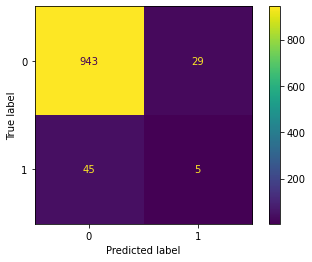

In [31]:
# Bernoulli Naive Bayes
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score


df_bernoulli = df.copy()

X = df_bernoulli.drop(y_fieldname, axis=1)
y = df_bernoulli[y_fieldname]


bern_X_train, bern_X_test, bern_y_train, bern_y_test = train_test_split(
    X, 
    y,
    stratify=df_bernoulli[y_fieldname],
    test_size=0.2, 
    random_state=42
)

float_columns = ['age', 'avg_glucose_level', 'bmi']


scaler = StandardScaler()

# Fit the scaler on the training data without outliers
scaler.fit(bern_X_train[float_columns])

# Transform both the training and test sets
bern_X_train[float_columns] = scaler.transform(bern_X_train[float_columns])
bern_X_test[float_columns] = scaler.transform(bern_X_test[float_columns])



# Calculate the IQR for these columns
Q1 = bern_X_train[float_columns].quantile(0.25)
Q3 = bern_X_train[float_columns].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Crea una maschera per definire chi si trova nel range
mask = (bern_X_train[float_columns] >= lower_bound) & (bern_X_train[float_columns] <= upper_bound)

# We want to keep rows where all column conditions are True, so we use 'all' across the columns
mask = mask.all(axis=1)

# print(mask)

# Output -> [True, False, True, True, False, ...]

# Apply the mask to the DataFrame to filter out outliers
bern_X_train = bern_X_train[mask]
bern_y_train = bern_y_train[mask]

bern_X_test[float_columns].clip(
    lower=lower_bound, 
    upper=upper_bound, 
    axis=1
)


for col in float_columns:
    print(f"Mean for {col} -> {bern_X_train[col].mean()}")
    bern_X_train[col] = (bern_X_train[col] > bern_X_train[col].mean()).astype(int)
    bern_X_test[col] = (bern_X_test[col] > bern_X_train[col].mean()).astype(int)

print(f'bern_X_train shape -> {bern_X_train.shape}')
print(f'bern_X_test shape  -> {bern_X_test.shape}')

bernoulli_nb_classifier = BernoulliNB()
bernoulli_nb_classifier.fit(bern_X_train, bern_y_train)
bern_nb_preds = bernoulli_nb_classifier.predict(bern_X_test)
evaluate(bernoulli_nb_classifier, bern_X_test, bern_y_test, bern_nb_preds)
print(classification_report(bern_y_test, bern_nb_preds))


# cv_scores = cross_val_score(nb_classifier, X_train, y_train, cv=5)
# print(cv_scores)

gauss_X_train shape -> (3511, 3)
gauss_X_test shape  -> (1022, 3)
True negatives:  921

False positives:  51

False negatives:  36

True Positives:  14
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       972
           1       0.22      0.28      0.24        50

    accuracy                           0.91      1022
   macro avg       0.59      0.61      0.60      1022
weighted avg       0.93      0.91      0.92      1022



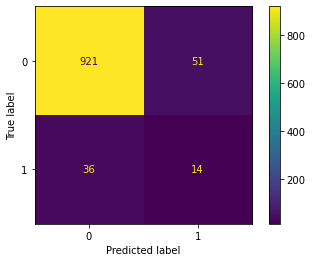

In [32]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score



df_gauss = df.copy()[['avg_glucose_level', 'bmi', 'age', 'stroke']]

X = df_gauss.drop(y_fieldname, axis=1)
y = df_gauss[y_fieldname]


gauss_X_train, gauss_X_test, gauss_y_train, gauss_y_test = train_test_split(
    X, 
    y,
    stratify=df_gauss[y_fieldname],
    test_size=0.2, 
    random_state=42
)


scaler = StandardScaler()

# Fit the scaler on the training data without outliers
scaler.fit(gauss_X_train[float_columns])

# Transform both the training and test sets
gauss_X_train[float_columns] = scaler.transform(gauss_X_train[float_columns])
gauss_X_test[float_columns] = scaler.transform(gauss_X_test[float_columns])



# Calculate the IQR for these columns
Q1 = gauss_X_train[float_columns].quantile(0.25)
Q3 = gauss_X_train[float_columns].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Crea una maschera per definire chi si trova nel range
mask = (gauss_X_train[float_columns] >= lower_bound) & (gauss_X_train[float_columns] <= upper_bound)

# We want to keep rows where all column conditions are True, so we use 'all' across the columns
mask = mask.all(axis=1)

# print(mask)

# Output -> [True, False, True, True, False, ...]

# Apply the mask to the DataFrame to filter out outliers
gauss_X_train = gauss_X_train[mask]
gauss_y_train = gauss_y_train[mask]

gauss_X_test[float_columns].clip(
    lower=lower_bound, 
    upper=upper_bound, 
    axis=1
)

print(f'gauss_X_train shape -> {gauss_X_train.shape}')
print(f'gauss_X_test shape  -> {gauss_X_test.shape}')

gaussian_nb_classifier = GaussianNB()
gaussian_nb_classifier.fit(gauss_X_train, gauss_y_train)
gaussian_nb_preds = gaussian_nb_classifier.predict(gauss_X_test)
evaluate(gaussian_nb_classifier, gauss_X_test, gauss_y_test, gaussian_nb_preds)
print(classification_report(gauss_y_test, gaussian_nb_preds))


# cv_scores = cross_val_score(nb_classifier, X_train, y_train, cv=5)
# print(cv_scores)

knn_X_train shape -> (3511, 3)
knn_X_test shape  -> (1022, 3)
True negatives:  950

False positives:  22

False negatives:  47

True Positives:  3
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       972
           1       0.12      0.06      0.08        50

    accuracy                           0.93      1022
   macro avg       0.54      0.52      0.52      1022
weighted avg       0.91      0.93      0.92      1022



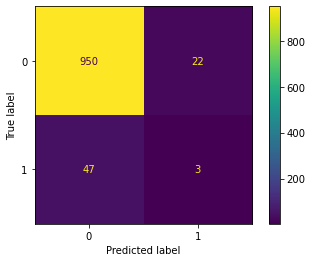

In [33]:
from sklearn.neighbors import KNeighborsClassifier


df_knn = df.copy()[['avg_glucose_level', 'bmi', 'age', 'stroke']]

X = df_knn.drop(y_fieldname, axis=1)
y = df_knn[y_fieldname]


knn_X_train, knn_X_test, knn_y_train, knn_y_test = train_test_split(
    X, 
    y,
    stratify=df_knn[y_fieldname],
    test_size=0.2, 
    random_state=42
)


scaler = StandardScaler()

# Fit the scaler on the training data without outliers
scaler.fit(knn_X_train[float_columns])

# Transform both the training and test sets
knn_X_train[float_columns] = scaler.transform(knn_X_train[float_columns])
knn_X_test[float_columns] = scaler.transform(knn_X_test[float_columns])



# Calculate the IQR for these columns
Q1 = knn_X_train[float_columns].quantile(0.25)
Q3 = knn_X_train[float_columns].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Crea una maschera per definire chi si trova nel range
mask = (knn_X_train[float_columns] >= lower_bound) & (knn_X_train[float_columns] <= upper_bound)

# We want to keep rows where all column conditions are True, so we use 'all' across the columns
mask = mask.all(axis=1)

# print(mask)

# Output -> [True, False, True, True, False, ...]

# Apply the mask to the DataFrame to filter out outliers
knn_X_train = knn_X_train[mask]
knn_y_train = knn_y_train[mask]

knn_X_test[float_columns].clip(
    lower=lower_bound, 
    upper=upper_bound, 
    axis=1
)

print(f'knn_X_train shape -> {knn_X_train.shape}')
print(f'knn_X_test shape  -> {knn_X_test.shape}')


knn_classifier = KNeighborsClassifier(n_neighbors=3)

knn_classifier.fit(knn_X_train, knn_y_train)
knn_preds = knn_classifier.predict(knn_X_test)

evaluate(knn_classifier, knn_X_test, knn_y_test, knn_preds)
print(classification_report(knn_y_test, knn_preds))

svm_X_train shape -> (3511, 3)
svm_X_test shape  -> (1022, 3)
True negatives:  972

False positives:  0

False negatives:  50

True Positives:  0
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



/Users/giumast/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/giumast/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/giumast/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

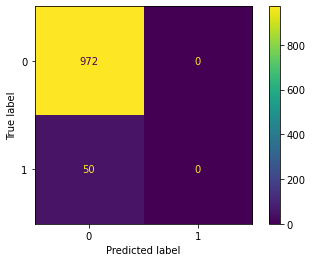

In [34]:
from sklearn.svm import SVC



df_svm = df.copy()[['avg_glucose_level', 'bmi', 'age', 'stroke']]

X = df_svm.drop(y_fieldname, axis=1)
y = df_svm[y_fieldname]


svm_X_train, svm_X_test, svm_y_train, svm_y_test = train_test_split(
    X, 
    y,
    stratify=df_svm[y_fieldname],
    test_size=0.2, 
    random_state=42
)


scaler = StandardScaler()

# Fit the scaler on the training data without outliers
scaler.fit(svm_X_train[float_columns])

# Transform both the training and test sets
svm_X_train[float_columns] = scaler.transform(svm_X_train[float_columns])
svm_X_test[float_columns] = scaler.transform(svm_X_test[float_columns])



# Calculate the IQR for these columns
Q1 = svm_X_train[float_columns].quantile(0.25)
Q3 = svm_X_train[float_columns].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Crea una maschera per definire chi si trova nel range
mask = (svm_X_train[float_columns] >= lower_bound) & (svm_X_train[float_columns] <= upper_bound)

# We want to keep rows where all column conditions are True, so we use 'all' across the columns
mask = mask.all(axis=1)

# print(mask)

# Output -> [True, False, True, True, False, ...]

# Apply the mask to the DataFrame to filter out outliers
svm_X_train = svm_X_train[mask]
svm_y_train = svm_y_train[mask]

svm_X_test[float_columns].clip(
    lower=lower_bound, 
    upper=upper_bound, 
    axis=1
)

print(f'svm_X_train shape -> {svm_X_train.shape}')
print(f'svm_X_test shape  -> {svm_X_test.shape}')


svm_classifier = SVC(
    kernel='rbf',
    probability=True # ci dà accesso al numero calcolato effettivamente, non solo alla label di uscita
)
# svm_classifier = SVC(kernel='rbf') 

svm_classifier.fit(svm_X_train, svm_y_train)
svm_preds = svm_classifier.predict(svm_X_test)
evaluate(svm_classifier, svm_X_test, svm_y_test, svm_preds)
print(classification_report(svm_y_test, svm_preds))

rf_X_train shape -> (3511, 3)
rf_X_test shape  -> (1022, 3)


/Users/giumast/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/giumast/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/giumast/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

True negatives:  972

False positives:  0

False negatives:  50

True Positives:  0
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



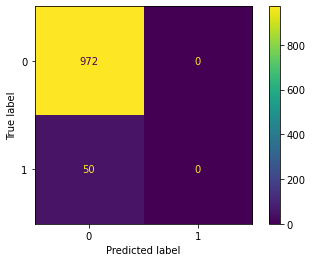

In [35]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier


df_rf = df.copy()[['avg_glucose_level', 'bmi', 'age', 'stroke']]

X = df_rf.drop(y_fieldname, axis=1)
y = df_rf[y_fieldname]


rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(
    X, 
    y,
    stratify=df_rf[y_fieldname],
    test_size=0.2, 
    random_state=42
)


scaler = StandardScaler()

# Fit the scaler on the training data without outliers
scaler.fit(rf_X_train[float_columns])

# Transform both the training and test sets
rf_X_train[float_columns] = scaler.transform(rf_X_train[float_columns])
rf_X_test[float_columns] = scaler.transform(rf_X_test[float_columns])



# Calculate the IQR for these columns
Q1 = rf_X_train[float_columns].quantile(0.25)
Q3 = rf_X_train[float_columns].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Crea una maschera per definire chi si trova nel range
mask = (rf_X_train[float_columns] >= lower_bound) & (rf_X_train[float_columns] <= upper_bound)

# We want to keep rows where all column conditions are True, so we use 'all' across the columns
mask = mask.all(axis=1)

# print(mask)

# Output -> [True, False, True, True, False, ...]

# Apply the mask to the DataFrame to filter out outliers
rf_X_train = rf_X_train[mask]
rf_y_train = rf_y_train[mask]

rf_X_test[float_columns].clip(
    lower=lower_bound, 
    upper=upper_bound, 
    axis=1
)

print(f'rf_X_train shape -> {rf_X_train.shape}')
print(f'rf_X_test shape  -> {rf_X_test.shape}')





rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=3
)

rf_classifier.fit(rf_X_train, rf_y_train)
rf_preds = rf_classifier.predict(rf_X_test)
evaluate(rf_classifier, rf_X_test, rf_y_test, rf_preds)
print(classification_report(rf_y_test, rf_preds))


In [36]:
# Calcoliamo la AUC per i modelli. predict_proba ci restituisce il numero finale che verrà arrotondato alla classe finale

knn_probs = knn_classifier.predict_proba(knn_X_test)
svm_probs = svm_classifier.predict_proba(svm_X_test)
gaussian_nb_probs  = gaussian_nb_classifier.predict_proba(gauss_X_test)
bernoulli_nb_probs  = bernoulli_nb_classifier.predict_proba(bern_X_test)
rf_probs  = rf_classifier.predict_proba(rf_X_test)


print(svm_classifier.predict_proba(svm_X_test)[0])
print(svm_classifier.predict(svm_X_test)[0])



[0.94007451 0.05992549]
0


In [37]:
svm_preds = svm_probs[:,1]
svm_fpr, svm_tpr, svm_threshold = roc_curve(svm_y_test, svm_preds)
svm_auc = roc_auc_score(svm_y_test, svm_preds)

knn_preds = knn_probs[:,1]
knn_fpr, knn_tpr, knn_threshold = roc_curve(knn_y_test, knn_preds)
knn_auc = roc_auc_score(knn_y_test, knn_preds)

gaussian_nb_preds = gaussian_nb_probs[:,1]
gaussian_nb_fpr, gaussian_nb_tpr, gaussian_nb_threshold = roc_curve(gauss_y_test, gaussian_nb_preds)
gaussian_nb_auc = roc_auc_score(gauss_y_test, gaussian_nb_preds)

bernoulli_nb_preds = bernoulli_nb_probs[:,1]
bernoulli_nb_fpr, bernoulli_nb_tpr, bernoulli_nb_threshold = roc_curve(bern_y_test, bern_nb_preds)
bernoulli_nb_auc = roc_auc_score(bern_y_test, bern_nb_preds)

rf_preds = rf_probs[:,1]
rf_fpr, rf_tpr, rf_threshold = roc_curve(rf_y_test, rf_preds)
rf_auc = roc_auc_score(rf_y_test, rf_preds)

print("SVM ROC AUC {}".format(svm_auc))
print("KNN ROC AUC {}".format(knn_auc))
print("Gaussian NB  ROC AUC {}".format(gaussian_nb_auc))
print("Bernoulli NB  ROC AUC {}".format(bernoulli_nb_auc))
print("RF  ROC AUC {}".format(rf_auc))

SVM ROC AUC 0.7545679012345679
KNN ROC AUC 0.6433230452674896
Gaussian NB  ROC AUC 0.8147736625514405
Bernoulli NB  ROC AUC 0.5350823045267491
RF  ROC AUC 0.8093415637860082


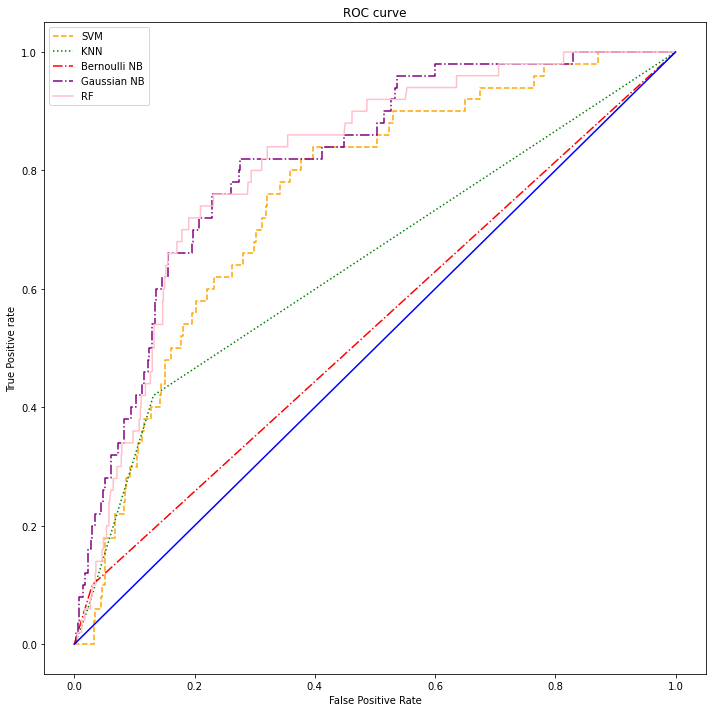

In [38]:
plt.figure(figsize=(10,10))
# plt.style.use('seaborn')
plt.plot(svm_fpr, svm_tpr, linestyle='--',color='orange', label='SVM')
plt.plot(knn_fpr, knn_tpr, linestyle='dotted',color='green', label='KNN')
plt.plot(bernoulli_nb_fpr, bernoulli_nb_tpr, linestyle='-.',color='red', label='Bernoulli NB')
plt.plot(gaussian_nb_fpr, gaussian_nb_tpr, linestyle='-.',color='purple', label='Gaussian NB')
plt.plot(rf_fpr, rf_tpr, color='pink', label='RF')
plt.plot([0, 1], [0, 1], color="blue")


# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.tight_layout()
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

### Lavorare con la curva ROC e AUC

È possibile **massimizzare** la performance di un classificatore senza riaddestrarlo ricorrendo alla scelta della soglia ottimale. 

L'espressione `rf_tpr + (1 - rf_fpr)` combina la **Sensitivity** (_True Positive Rate_, TPR) con il complemento del **Tasso di Falsi Positivi** (_False Positive Rate_, FPR), che se sottratto ad 1 rappresenta la **Specificity** (_True Negative Rate_). Questa combinazione è nota anche come [indice di Youden](https://en.wikipedia.org/wiki/Youden%27s_J_statistic), che varia da 0 a 1, dove un valore più alto indica una migliore capacità discriminante del modello.

### Obiettivi dell'espressione
- **Massimizzare la Sensibilità** (TPR): aumentare la proporzione dei positivi reali correttamente identificati.
- **Massimizzare la Specificità** (1 - FPR): aumentare la proporzione dei negativi reali correttamente identificati.

### Relazione con la curva ROC e l'AUC
- La **Curva ROC** mostra la capacità diagnostica di un classificatore binario al variare della soglia di discriminazione, rappresentando TPR contro FPR.
- L'**AUC** (_Area Under the ROC Curve_) misura l'area totale sotto la curva ROC. Un AUC elevato indica una migliore performance complessiva del classificatore.
- Massimizzare `rf_tpr + (1 - rf_fpr)` aiuta a trovare il punto ottimale sulla curva ROC che equilibra sensibilità e specificità, spostandosi idealmente verso l'angolo superiore sinistro del grafico (alta TPR, bassa FPR).

True negatives:  768

False positives:  204

False negatives:  14

True Positives:  36


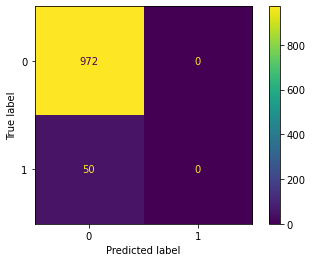

In [39]:


optimal_threshold_auc = rf_threshold[np.argmax(rf_tpr + (1 - rf_fpr))]
predictions_auc = (rf_preds > optimal_threshold_auc).astype(int)


evaluate(rf_classifier, rf_X_test, rf_y_test, predictions_auc)
# print(classification_report(rf_y_test, predictions_auc))

In [40]:
num_rows = df_encoded.shape[0] # Quante righe abbiamo nel dataset
zero_labels_num = len(df_encoded[df_encoded[y_fieldname] == 0] ) # Label pari a zero
one_labels_num  = len(df_encoded[df_encoded[y_fieldname] == 1] ) # Label pari a 1
percentage      = one_labels_num / num_rows # Percentuale delle righe pari a 1 risp. al numero totale

print("Numero di entries: {}".format(num_rows))
print("Senza infarto:     {}".format(zero_labels_num))
print("Con infarto:       {}".format(one_labels_num))
print("Sbilanciamento:    {}".format(percentage))


Numero di entries: 4383
Senza infarto:     4219
Con infarto:       164
Sbilanciamento:    0.03741729409080539


In [41]:
# LogLoss

dummy_preds = [percentage]*len(X_test) # Queste saranno NON le predizioni ma le probabilità
# [0.037, 0.037, 0.037, 0.037, ... x1228 (grandezza del dataset di test)]
baseline_log_loss = log_loss(y_test, dummy_preds)
print("Baseline Log Loss: {}".format(baseline_log_loss))

# Questo valore rappresenta il valore di riferimento sul quale andremo a valutare il logloss del modello.
# Se il logloss del modello ha un punteggio maggiore di questo -> performa peggio delle predizioni "dummy"
# Se il logloss del modello ha un punteggio minore di questo   -> performa MEGLIO delle predizioni "dummy"


Baseline Log Loss: 0.1596197466487641


In [42]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='prior', random_state=42) # "prior" -> stima della probabilità pari a 0.037
# the class prior is an estimate of the probability that randomly sampling an instance from a population will yield the given class



X_train, X_test, y_train, y_test = train_test_split(
    df_encoded, 
    df_encoded[y_fieldname], 
    stratify=df_encoded[y_fieldname], 
    random_state=0
)
X_train.drop([y_fieldname], axis=1)
X_test.drop([y_fieldname], axis=1)



dummy.fit(X_train, y_train)
dummy_probs = dummy.predict_proba(X_test)
dummy_logloss = log_loss(y_test, dummy_probs[:, 1])
print(f"Dummy Classifier LogLoss: {dummy_logloss}")

Dummy Classifier LogLoss: 0.15961974743554375


In [43]:
svm_ll = log_loss(svm_y_test, svm_preds)
knn_ll = log_loss(knn_y_test, knn_preds)
gaussian_nb_ll = log_loss(gauss_y_test, gaussian_nb_preds)
bernoulli_nb_ll = log_loss(bern_y_test, bernoulli_nb_preds)
rf_ll = log_loss(rf_y_test, rf_preds)

print(f"SVM    LogLoss {svm_ll:15}")
print(f"KNN    LogLoss {knn_ll:15}")
print(f"Gaussian NB     LogLoss {gaussian_nb_ll:15}")
print(f"Bernoulli NB     LogLoss {bernoulli_nb_ll:15}")
print(f"RF     LogLoss {rf_ll:15}")
print(f"Dummy  LogLoss {dummy_logloss:15}")



SVM    LogLoss 0.5411239162432038
KNN    LogLoss 1.0990270719046944
Gaussian NB     LogLoss 0.23661622220714273
Bernoulli NB     LogLoss 0.21245188131802323
RF     LogLoss 0.16631424777355402
Dummy  LogLoss 0.15961974743554375


# Class Weights

In [44]:
num_classes = 2


weight_for_0 = num_rows / (num_classes * zero_labels_num)
weight_for_1 = num_rows / (num_classes * one_labels_num)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(df_encoded[y_fieldname]), 
    y=df_encoded[y_fieldname]
)

print(class_weights)

class_weight_dict = dict(enumerate(class_weights))
# class_weight_dict = dict(zip(np.unique(df_encoded[y_fieldname]), class_weights))


print(class_weight_dict)

Weight for class 0: 0.52
Weight for class 1: 13.36
[ 0.51943589 13.36280488]
{0: 0.5194358852808723, 1: 13.362804878048781}


True negatives:  596

False positives:  376

False negatives:  10

True Positives:  40
              precision    recall  f1-score   support

           0       0.98      0.61      0.76       972
           1       0.10      0.80      0.17        50

    accuracy                           0.62      1022
   macro avg       0.54      0.71      0.46      1022
weighted avg       0.94      0.62      0.73      1022



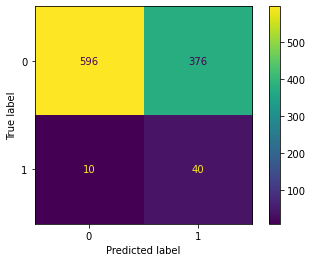

In [45]:
from sklearn.svm import SVC

svm_classifier = SVC(
    kernel='rbf',
    probability=True, # ci dà accesso al numero calcolato effettivamente, non solo alla label di uscita
    class_weight="balanced" # equivalente a class_weight=class_weight_dict
)
# svm_classifier = SVC(kernel='rbf') 

svm_classifier.fit(svm_X_train, svm_y_train)
preds = svm_classifier.predict(svm_X_test)
evaluate(svm_classifier, svm_X_test, svm_y_test, preds)
print(classification_report(svm_y_test, preds))

# Oversampling

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    df_encoded, 
    df_encoded[y_fieldname], 
    stratify=df_encoded[y_fieldname], 
    random_state=42
)

train_labels = np.array(X_train[y_fieldname])
train_features = np.array(X_train)
print(train_labels)
bool_train_labels = train_labels != 0
print(bool_train_labels)

print(len(bool_train_labels))
print(train_labels.shape)

[0 0 0 ... 0 0 0]
[False False False ... False False False]
3287
(3287,)


In [47]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

print("Positive -> ", pos_features.shape)
print("Negative -> ", neg_features.shape)

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

Positive ->  (123, 22)
Negative ->  (3164, 22)


In [48]:
len(pos_features)

123

In [49]:
ids = np.arange(len(pos_features))
print(ids)
choices = np.random.choice(ids, len(neg_features))

print(choices)

print(choices.shape)

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122]
[ 50  98  86 ...  57  79 111]
(3164,)


(3164, 22)

In [50]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(6328, 22)

In [51]:
resampled_df = pd.DataFrame(data=resampled_features, columns=df_encoded.columns.values)

In [52]:
resampled_df

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.582163,0.0,0.0,0.103852,-6.227195e-01,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.626390,0.0,1.0,-0.870769,-9.345186e-01,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.582163,0.0,0.0,0.103852,-6.227195e-01,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.741843,0.0,1.0,-0.314222,9.102926e-01,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.493708,0.0,0.0,-0.766527,-6.227195e-01,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6323,-0.142705,0.0,0.0,-1.049218,5.335354e-01,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6324,1.449481,0.0,0.0,-0.962423,4.615554e-16,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6325,-1.071479,0.0,0.0,-0.745546,4.615554e-16,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
6326,0.786070,1.0,0.0,-0.663389,-2.069874e-01,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [53]:
num_rows = resampled_df.shape[0] # Quante righe abbiamo nel dataset
zero_labels_num = len(resampled_df[resampled_df[y_fieldname] == 0] ) # Label pari a zero
one_labels_num  = len(resampled_df[resampled_df[y_fieldname] == 1] ) # Label pari a 1
percentage      = one_labels_num / num_rows # Percentuale delle righe pari a 1 risp. al numero totale

print("Numero di entries: {}".format(num_rows))
print("Senza infarto:     {}".format(zero_labels_num))
print("Con infarto:       {}".format(one_labels_num))
print("Sbilanciamento:    {}".format(percentage))


Numero di entries: 6328
Senza infarto:     3164
Con infarto:       3164
Sbilanciamento:    0.5


<AxesSubplot:title={'center':'Distribuzione'}, xlabel='stroke'>

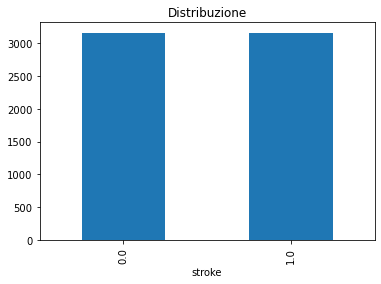

In [54]:
resampled_df.pivot_table(index=y_fieldname, aggfunc="size").plot(kind='bar', title="Distribuzione")

True negatives:  611

False positives:  180

False negatives:  49

True Positives:  742
              precision    recall  f1-score   support

         0.0       0.93      0.77      0.84       791
         1.0       0.80      0.94      0.87       791

    accuracy                           0.86      1582
   macro avg       0.87      0.86      0.85      1582
weighted avg       0.87      0.86      0.85      1582



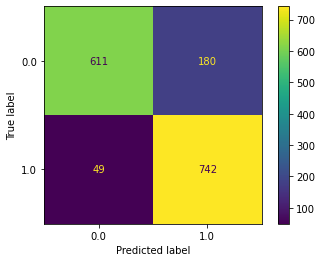

In [55]:
from sklearn.svm import SVC

svm_classifier = SVC(
    kernel='rbf',
    probability=True # ci dà accesso al numero calcolato effettivamente, non solo alla label di uscita
)
# svm_classifier = SVC(kernel='rbf') 


svm_X_train, svm_X_test, svm_y_train, svm_y_test = train_test_split(
    resampled_df, 
    resampled_df[y_fieldname], 
    stratify=resampled_df[y_fieldname], 
    random_state=42
)
svm_X_train.drop([y_fieldname], axis=1, inplace=True)
svm_X_test.drop([y_fieldname], axis=1, inplace=True)


svm_classifier.fit(svm_X_train, svm_y_train)
preds = svm_classifier.predict(svm_X_test)
evaluate(svm_classifier, svm_X_test, svm_y_test, preds)
print(classification_report(svm_y_test, preds))

(16876, 22)


<AxesSubplot:title={'center':'Distribuzione'}, xlabel='stroke'>

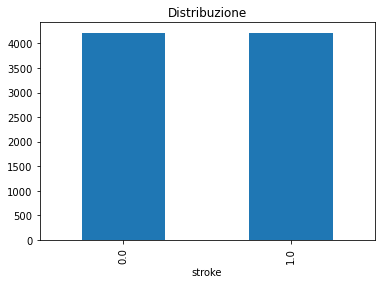

In [56]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy="auto", random_state=42)

X_resampled, y_resampled = smote.fit_resample(df_encoded.iloc[:,:-1], df_encoded[y_fieldname])
df_resampled = pd.concat([X_resampled, y_resampled])
print(df_resampled.shape)
df_resampled.pivot_table(index=y_fieldname, aggfunc="size").plot(kind='bar', title="Distribuzione")



